In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:




path_main = "/Users/erenakcanal/Documents/epfl_2nd_semester/comp_photo/compphoto_data/data/pixel_match"
name_color = "new_color_checkers.csv"
name_gray = "grays.csv"



In [3]:
# Construct full paths
path_color = os.path.join(path_main, name_color)
path_gray = os.path.join(path_main, name_gray)

# Check existence and read
if os.path.exists(path_color):
    data_color = pd.read_csv(path_color)
    print("Color data loaded successfully.")
else:
    print(f"File not found: {path_color}")
    data_color = None

if os.path.exists(path_gray):
    data_gray = pd.read_csv(path_gray)
    print("Gray data loaded successfully.")
else:
    print(f"File not found: {path_gray}")
    data_gray = None
    

Color data loaded successfully.
Gray data loaded successfully.


In [4]:
#drop rows with NaN values
data_color= data_color.dropna(axis=0)
data_gray= data_gray.dropna(axis=0)

In [5]:
#get DA_G DA_B
DSLR_matrix = np.array(data_color[[ "DA_B","DA_G", "DA_R"]])
DSLR_matrix = np.concatenate((DSLR_matrix, np.array(data_gray[ ["DA_B","DA_G", "DA_R"]])), axis=0)
print(DSLR_matrix.shape)

(1266, 3)


In [6]:
scan_1_matrix = np.array(data_color[[ "N1_B","N1_G", "N1_R"]])
scan_1_matrix = np.concatenate((scan_1_matrix, np.array(data_gray[ ["N1_B","N1_G", "N1_R"]])), axis=0)
print(scan_1_matrix.shape)


(1266, 3)


In [7]:
scan_2_matrix = np.array(data_color[[ "N2_B","N2_G", "N2_R"]])
scan_2_matrix = np.concatenate((scan_2_matrix, np.array(data_gray[ ["N2_B","N2_G", "N2_R"]])), axis=0)
print(scan_2_matrix.shape)


(1266, 3)


In [8]:
#normalize the data to range 0-1
DSLR_matrix = DSLR_matrix/255
DSLR_matrix=1-DSLR_matrix 
scan_1_matrix = scan_1_matrix/255
scan_2_matrix = scan_2_matrix/255

In [9]:
#convert to density domain
DSLR_matrix_log = -np.log10(np.clip(DSLR_matrix,1e-12,1))
scan_1_matrix_log = -np.log10(np.clip(scan_1_matrix,1e-12,1))
scan_2_matrix_log = -np.log10(np.clip(scan_2_matrix,1e-12,1))
ones = np.ones((scan_1_matrix_log.shape[0], 1))

In [ ]:
def fit_lsqe(data1,data2):


    
    # solves data2=data1*W
    ones = np.ones((data1.shape[0],1))
    data1_augmented = np.hstack([data1, ones])
    W = np.linalg.lstsq(data1_augmented, data2, rcond=None)[0]
    print(W)
    error =np.linalg.norm(data2 - data1_augmented@W,axis=1)
    print(np.mean(error))
    return W


In [11]:
W_1D_log1 = fit_lsqe(scan_1_matrix_log, DSLR_matrix_log)
#We can see that it only takes green channel. bad fit not generalizable
W_2D_log1= fit_lsqe(scan_2_matrix_log, DSLR_matrix_log)
#very bad fitting between scans
W_12_log1 = fit_lsqe(scan_1_matrix_log, scan_2_matrix_log)
W_21_log1  = fit_lsqe( scan_2_matrix_log,scan_1_matrix_log)

[[-0.00451835 -0.02181349 -0.02273328]
 [ 1.22416778  1.32296882  0.09678159]
 [-0.60635138  0.22779824  2.0270804 ]
 [ 0.17342735 -0.0232686  -0.1448142 ]]
0.20848712807841938
[[ 0.01500986 -0.00234271 -0.01082466]
 [ 1.31597301  1.60470109  1.26039936]
 [-0.07198011  0.0529483   0.18149281]
 [-0.09169454 -0.21881696 -0.12599643]]
0.19446863199217432
[[ 0.38731661 -0.01256667 -0.0149567 ]
 [-1.92817751  0.92326345 -1.13771745]
 [-0.62099726 -0.33469664  2.24530846]
 [ 0.98809593  0.20741626  0.31674628]]
0.8408908426133136
[[ 0.90840174  0.01072925  0.00248324]
 [-0.10042792  0.69381146  0.27441082]
 [-1.18802927 -0.03259449  0.04649926]
 [ 1.799946    0.04457166  0.15471953]]
1.5770996043032897


In [12]:
W_1D_lin1=fit_lsqe(scan_1_matrix,DSLR_matrix)
W_2D_lin1=fit_lsqe(scan_2_matrix,DSLR_matrix)
#for between scans we have a better fit in linear base
W_21_lin1 =fit_lsqe(scan_2_matrix,scan_1_matrix)

[[ 0.50258466 -0.79203785 -0.58437543]
 [ 0.44920274  1.5339104   0.30463247]
 [-0.14254286 -0.13133977  1.39508259]
 [ 0.22615688 -0.11015402 -0.32599703]]
0.2071301044733733
[[ 1.02662156 -0.09490815  0.2804218 ]
 [ 0.75178491  1.42376617  0.40458648]
 [ 0.41719016  0.22283199  1.77392109]
 [-0.2435954  -0.22044778 -0.29922165]]
0.15652945596672616
[[ 0.8283443   0.25333124  0.33275035]
 [ 0.15066975  0.81773077 -0.01474687]
 [-0.37149882 -0.27900385  0.76764875]
 [ 0.02720375  0.17202576  0.23937768]]
0.1138347357935142


In [13]:


#lets clean up the data and see if we can get a better fit
#first we avarage the same colors
data_avg_c = data_color.groupby(['pixel_num', 'image_id']).mean(numeric_only=True).reset_index()
data_avg_g = data_gray.groupby(['pixel_num', 'image_id']).mean(numeric_only=True).reset_index()


In [14]:
data_scan1_avg = np.array(data_avg_c[[ "N1_B","N1_G", "N1_R"]])
data_scan1_avg = np.concatenate((data_scan1_avg, np.array(data_avg_g[ ["N1_B","N1_G", "N1_R"]])), axis=0)
data_scan2_avg = np.array(data_avg_c[[ "N2_B","N2_G", "N2_R"]])
data_scan2_avg = np.concatenate((data_scan2_avg, np.array(data_avg_g[ ["N2_B","N2_G", "N2_R"]])), axis=0)
data_dslr_avg = np.array(data_avg_c[[ "DA_B","DA_G", "DA_R"]])
data_dslr_avg = np.concatenate((data_dslr_avg, np.array(data_avg_g[ ["DA_B","DA_G", "DA_R"]])), axis=0)

#normalize the data to range 0-1
data_scan1_avg = data_scan1_avg/255
data_scan2_avg = data_scan2_avg/255
data_dslr_avg = data_dslr_avg/255
data_dslr_avg = 1-data_dslr_avg
print("data_scan1_avg shape",data_scan1_avg.shape)
print("data_scan2_avg shape",data_scan2_avg.shape)
print("data_dslr_avg shape",data_dslr_avg.shape)

data_scan1_avg shape (140, 3)
data_scan2_avg shape (140, 3)
data_dslr_avg shape (140, 3)


In [15]:
W_1D_lin2 = fit_lsqe(data_scan1_avg,data_dslr_avg)
W_2D_lin2 = fit_lsqe(data_scan2_avg,data_dslr_avg)
W_21_lin2 = fit_lsqe(data_scan2_avg,data_scan1_avg)

[[ 0.49717374 -0.86449158 -0.64608781]
 [ 0.43119031  1.60652576  0.37809873]
 [-0.10603665 -0.16172856  1.33992305]
 [ 0.21791396 -0.11904852 -0.32549437]]
0.20256662573541948
[[ 1.13494068 -0.04500039  0.36861515]
 [ 0.71590188  1.43234071  0.38891322]
 [ 0.58012225  0.27863295  1.86506302]
 [-0.30112729 -0.25540611 -0.34487346]]
0.14363484505653945
[[ 0.89824817  0.31493226  0.40510247]
 [ 0.13054737  0.80913112 -0.04486603]
 [-0.32094858 -0.24185245  0.8409831 ]
 [ 0.0036222   0.1488794   0.21293068]]
0.10169477316899452


In [16]:
data_scan1_avg_log = -np.log10(np.clip(data_scan1_avg,1e-12,1))
data_scan2_avg_log = -np.log10(np.clip(data_scan2_avg,1e-12,1))
data_dslr_avg_log = -np.log10(np.clip(data_dslr_avg,1e-12,1))
W_1D_log2 = fit_lsqe(data_scan1_avg_log,data_dslr_avg_log)
W_2D_log2 = fit_lsqe(data_scan2_avg_log,data_dslr_avg_log)
W_21_log2 = fit_lsqe(data_scan2_avg_log,data_scan1_avg_log)

[[-0.00680563 -0.03046808 -0.03329554]
 [ 1.18005424  1.17345812 -0.03088576]
 [-0.5678331   0.27796886  2.03555946]
 [ 0.17369271 -0.00587691 -0.11994755]]
0.21371389323244197
[[ 0.01910365  0.00488502  0.00390865]
 [ 1.46199315  1.55445878  0.93769369]
 [-0.26226827  0.21979519  0.81051288]
 [-0.02751381 -0.30464314 -0.39753061]]
0.16244965412747386
[[ 0.99348597  0.01212935  0.00720479]
 [ 0.27579417  0.774297    0.18731734]
 [-2.50090914 -0.17360997  0.1950198 ]
 [ 1.78775713  0.10270381  0.0952021 ]]
0.5708143461838547


In [17]:
def plot_pixel_colors(data1,data2,title_str ,height=2000, width=1000):
    n = data1.shape[0]
    band_height = height // n

    # Initialize image (height, width, 3)
    img = np.ones((height, width, 3))

    for i in range(n):
        start = i * band_height
        end = (i + 1) * band_height if i < n - 1 else height

        img[start:end, :width//2, :] = data1[i]
        img[start:end, width//2:, :] = data2[i]

    # Show the image
    plt.figure(figsize=(2, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title_str+"\n"+"Left: GT | Right: Predicted")
    plt.show()
    

In [18]:
def exp__do_on_RGB(data_scan1_avg,data_scan2_avg,data_dslr_avg,W_1D_lin1,W_2D_lin1,W_21_lin1  ):
    ones = np.ones((data_scan1_avg.shape[0],1))
    data1_augmented = np.hstack([data_scan1_avg, ones])
    dslr_predicted = data1_augmented @ W_1D_lin1
    plot_pixel_colors(data_dslr_avg,dslr_predicted,"data1_augmented->dslr_predicted")

    data2_augmented = np.hstack([data_scan2_avg, ones])
    dslr_predicted = data2_augmented @ W_2D_lin1
    plot_pixel_colors(data_dslr_avg,dslr_predicted,"data2_augmented->dslr_predicted")

    s1_predicted = data2_augmented @ W_21_lin1
    plot_pixel_colors(data_scan1_avg,s1_predicted,"data2_augmented->data1_predicted")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0219607843137255..1.0782749021180202].


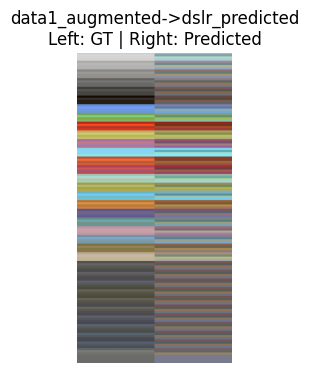

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0219607843137255..1.093905611431727].


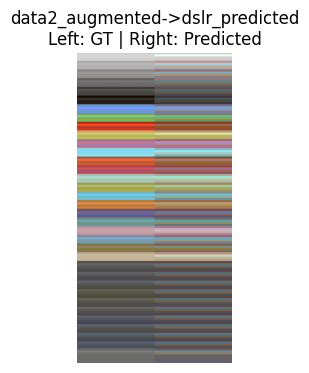

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07802183631859966..0.8827450980392156].


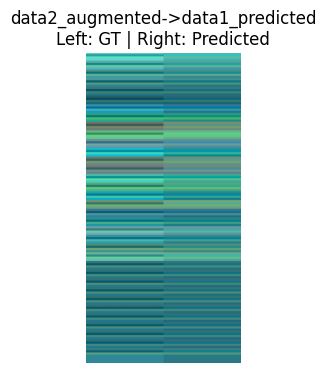

In [19]:

#see the results train o whole set
exp__do_on_RGB(data_scan1_avg,data_scan2_avg,data_dslr_avg,W_1D_lin1,W_2D_lin1,W_21_lin1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0219607843137255..1.0875832304715902].


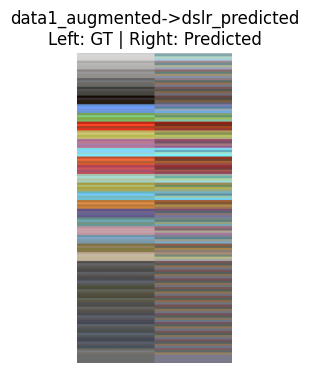

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0219607843137255..1.1127519333105194].


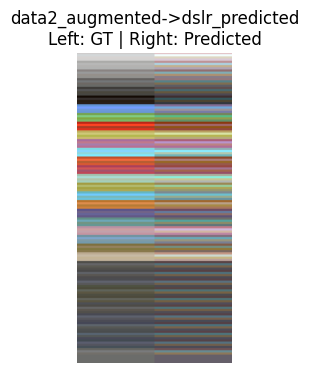

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08701377035005531..0.8827450980392156].


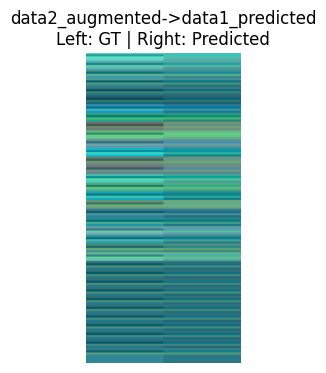

In [20]:
#see the results trained on avaraged set
exp__do_on_RGB(data_scan1_avg,data_scan2_avg,data_dslr_avg,W_1D_lin2,W_2D_lin2,W_21_lin2)

In [21]:
def exp__do_on_density(data_scan1_avg,data_scan2_avg,data_dslr_avg,W_1D_log2,W_2D_log2,W_21_log2  ):

    ones = np.ones((data_scan1_avg.shape[0],1))

    data_scan1_avg_log = -np.log10(np.clip(data_scan1_avg,1e-12,1))
    data_scan2_avg_log = -np.log10(np.clip(data_scan2_avg,1e-12,1))

    s1_augmented_log = np.hstack([data_scan1_avg_log, ones])
    s2_augmented_log = np.hstack([data_scan2_avg_log, ones])
    

    dslr_predicted_log_s1 = np.clip(s1_augmented_log@W_1D_log2,0,12)
    dslr_predicted_log_s2 = np.clip(s2_augmented_log@W_2D_log2,0,12)
    s2_predicted_log_s1 = np.clip(s2_augmented_log@W_21_log2,0,12)

    dslr_predicted_linear_s1 = np.clip(np.pow(10,-dslr_predicted_log_s1),0,1)
    dslr_predicted_linear_s2 = np.clip(np.pow(10,-dslr_predicted_log_s2),0,1)
    s2_predicted_linear_s1 = np.clip(np.pow(10,-s2_predicted_log_s1),0,1)

    plot_pixel_colors(data_dslr_avg,dslr_predicted_linear_s1,"data1_augmented->dslr_predicted w density transforms")
    plot_pixel_colors(data_dslr_avg,dslr_predicted_linear_s2,"data2_augmented->dslr_predicted w density transforms")
    plot_pixel_colors(data_scan2_avg,s2_predicted_linear_s1,"data2_augmented->data1_predicted w density transforms")


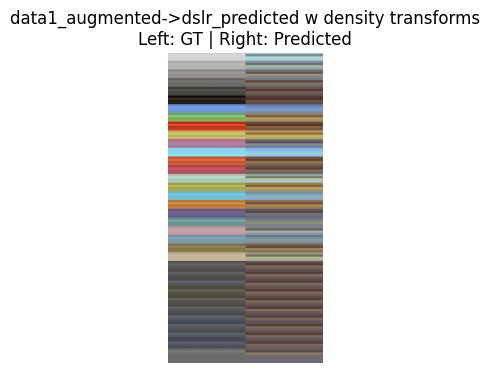

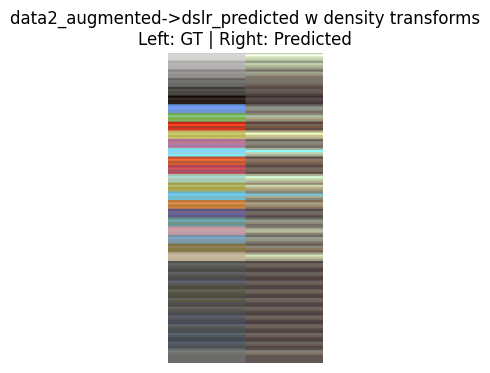

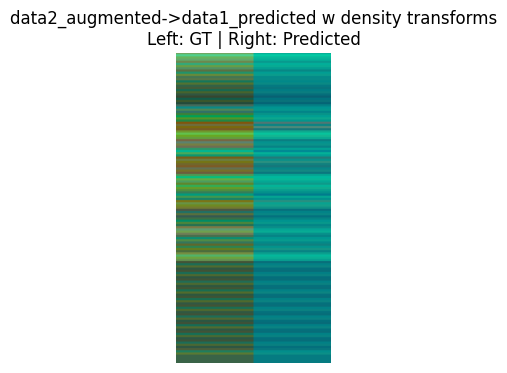

In [22]:
#try on all data
exp__do_on_density(data_scan1_avg,data_scan2_avg,data_dslr_avg,W_1D_log1,W_2D_log1,W_21_log1)


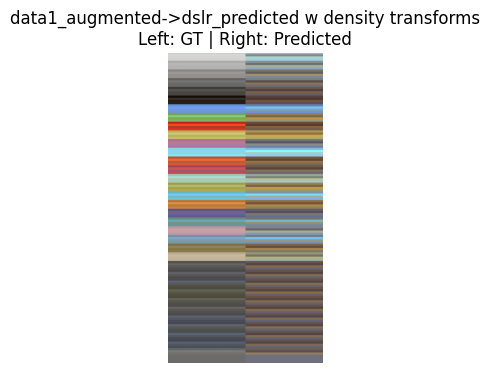

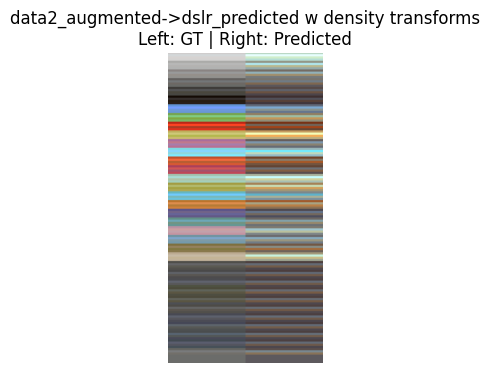

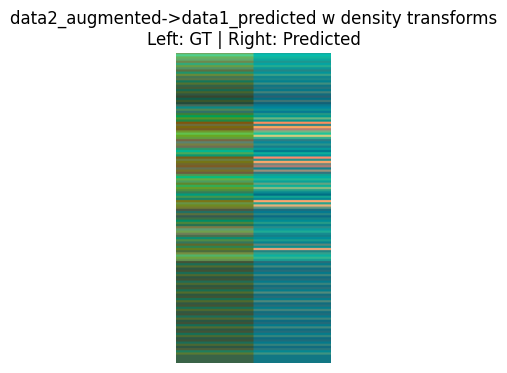

In [23]:
#try on avaraged data
exp__do_on_density(data_scan1_avg,data_scan2_avg,data_dslr_avg,W_1D_log2,W_2D_log2,W_21_log2)

[[ 0.22636603  0.02507797  0.13242963]
 [-0.55963699  1.07683736 -0.67692533]
 [-0.69743787 -0.40919383  1.89590722]
 [-0.28335128 -0.04446056 -0.19186042]]
0.26936200793420845
(140, 3)
(140, 3)


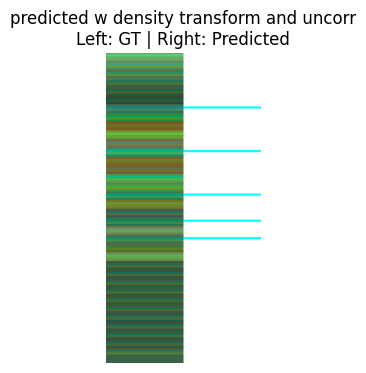

array([[ 0.22636603,  0.02507797,  0.13242963],
       [-0.55963699,  1.07683736, -0.67692533],
       [-0.69743787, -0.40919383,  1.89590722],
       [-0.28335128, -0.04446056, -0.19186042]])

In [25]:
def lsqe_density_uncor(X,Y):
    # solves Y = X*A
    X_log = -np.log10(np.clip(X,1e-12,1))
    Y_log = -np.log10(np.clip(Y,1e-12,1))
    ones = np.ones((X_log.shape[0],1))
    
    X_mean = np.mean(X_log, axis=1, keepdims=True)  # shape (n_samples, 1)
    X_mean_stacked = np.hstack([X_mean] * 3)        # shape (n_samples, 3)
    
    X_log_uncorrelated = 0.5 * X_mean_stacked - X_log
    
    #X_log_uncorrelated = np.clip(X_log_uncorrelated, 0, 12)

    Y_mean = np.mean(Y_log, axis=1, keepdims=True)  # shape (n_samples, 1)
    Y_mean_stacked = np.hstack([Y_mean] * 3)        # shape (n_samples, 3)
    Y_log_uncorrelated = 0.5 * Y_mean_stacked - Y_log
    #Y_log_uncorrelated = np.clip(Y_log_uncorrelated, 0, 12)

    W = fit_lsqe(X_log_uncorrelated, Y_log_uncorrelated)

    X_log_uncorrelated_augmented = np.hstack([X_log_uncorrelated, ones])
    Y_predicted_ucorr = X_log_uncorrelated_augmented @ W
    
    Y_predicted_corr = np.stack([
    Y_predicted_ucorr[:, 1] + Y_predicted_ucorr[:, 2],
    Y_predicted_ucorr[:, 0] + Y_predicted_ucorr[:, 2],
    Y_predicted_ucorr[:, 0] + Y_predicted_ucorr[:, 1]
    ], axis=1)
    
    Y_predicted_corr = np.clip(Y_predicted_corr, 0, 12)
    Y_predicted_linear =np.clip( 10**(-Y_predicted_corr),0,1)

    print(Y.shape)
    print(Y_predicted_linear.shape)
    plot_pixel_colors(Y,Y_predicted_linear,"predicted w density transform and uncorr")
    return W

    

lsqe_density_uncor(data_scan1_avg,data_scan2_avg)

In [29]:
def SolveRidgeRegression(X, y):
    wRR_list = []
    df_list = []
    for i in range(0, 5001, 1):
        lam_par = i
        xtranspose = np.transpose(X)
        xtransx = np.dot(xtranspose, X)
        if xtransx.shape[0] != xtransx.shape[1]:
            raise ValueError('Needs to be a square matrix for inverse')
        lamidentity = np.identity(xtransx.shape[0]) * lam_par
        matinv = np.linalg.inv(lamidentity + xtransx)
        xtransy = np.dot(xtranspose, y)
        wRR = np.dot(matinv, xtransy)
        _, S, _ = np.linalg.svd(X)
        df = np.sum(np.square(S) / (np.square(S) + lam_par))
        wRR_list.append(wRR)
        df_list.append(df)
    return wRR_list, df_list

In [34]:
def makeDFPlots(dfArray, wRRArray):
    #print wRR_array.shape, df_array.shape
    plt.figure()
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    labels = ["Dimension 1", "Dimension 2", "Dimension 3","constant"]
    for i in range(0, wRRArray[0].shape[0]):
        plt.plot(dfArray, wRRArray[:,i], color = colors[i])
        plt.scatter(dfArray, wRRArray[:,i], color = colors[i], s = 8, label=labels[i])
    # df(lambda)
    plt.xlabel(r"df($\lambda$)")
    # and a legend
    plt.legend(loc='lower left')
    plt.show()
    

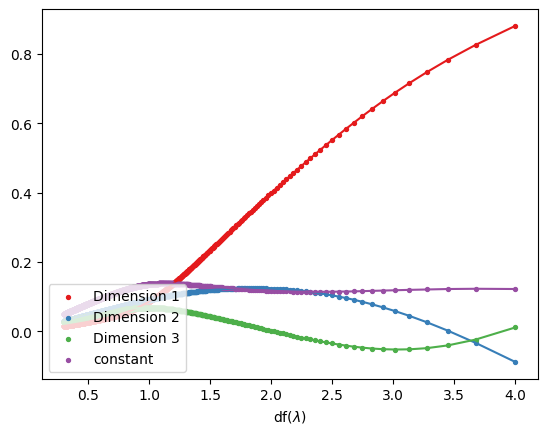

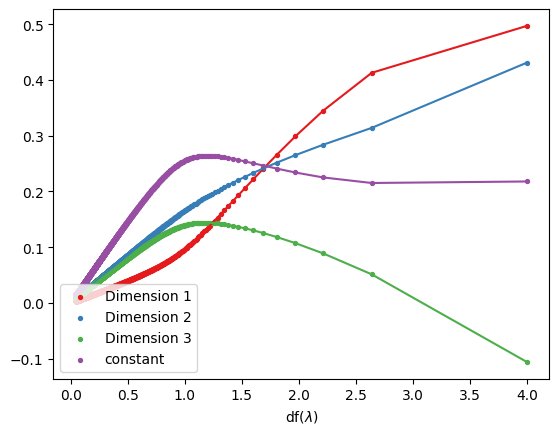

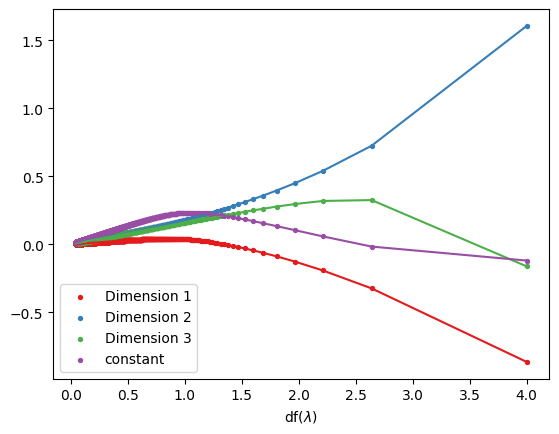

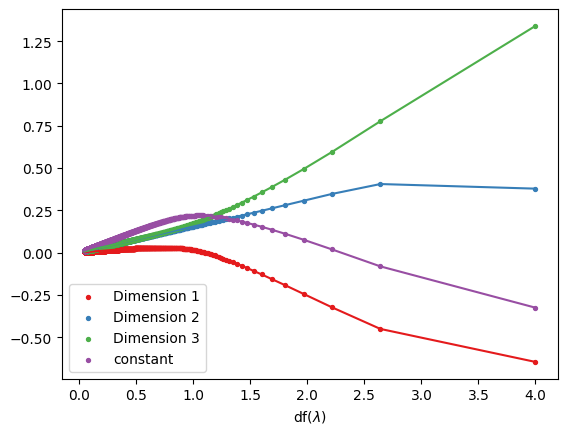

In [55]:
ones = np.ones((data_scan1_avg.shape[0],1))
scan_1_augmented = np.hstack([data_scan1_avg, ones])
y = data_dslr_avg

wRR_list, df_list = SolveRidgeRegression(scan_1_augmented, y[:,0])
wRRArray1 = np.asarray(wRR_list)
dfArray1 = np.asarray(df_list)
makeDFPlots(dfArray1, wRRArray1)


wRR_list, df_list = SolveRidgeRegression(scan_1_augmented, y[:,1])
wRRArray2 = np.asarray(wRR_list)
dfArray2 = np.asarray(df_list)
makeDFPlots(dfArray2, wRRArray2)

wRR_list, df_list = SolveRidgeRegression(scan_1_augmented, y[:,2])
wRRArray3 = np.asarray(wRR_list)
dfArray3 = np.asarray(df_list)
makeDFPlots(dfArray3, wRRArray3)

In [56]:
#lambda_try = [1.5, 2, 2.5, 3, 3.5, 4]
def plotRMSEValue(max_lamda, RMSE_list, poly):
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
    legend = ["Polynomial Order, p = 1", "Polynomial Order, p = 2", "Polynomial Order, p = 3"]
    plt.plot(range(len(RMSE_list)), RMSE_list, color = colors[poly])
    plt.scatter(range(len(RMSE_list)), RMSE_list, color = colors[poly] , s = 8, label= legend[poly-1])
    # df(lambda)
    plt.xlabel("$\lambda$")
    plt.ylabel("RMSE")
    # and a legend
    plt.legend(loc='upper left')
    plt.title("RMSE vs $\lambda$ values for the test set, $\lambda$ = 0..%d"%(max_lamda))
def getRMSEValues(X_test, y_test, wRRArray, max_lamda, poly):
    RMSE_list = []
    for lamda in range(0, max_lamda+1):
        wRRvals = wRRArray[lamda]
        y_pred = np.dot(X_test, wRRvals)
        RMSE = np.sqrt(np.sum(np.square(y_test - y_pred))/len(y_test))
        RMSE_list.append(RMSE)
    plotRMSEValue(max_lamda, RMSE_list, poly=poly)

plt.figure()
getRMSEValues(scan_1_augmented, scan_2_matrix[:,0], wRRArray1, max_lamda=50, poly=1)
plt.show()

ValueError: operands could not be broadcast together with shapes (1266,) (140,) 

<Figure size 640x480 with 0 Axes>

In [57]:
def inference(X_test,  wRRvals1,wRRvals2,wRRvals3):
    
    y_pred1 = np.dot(X_test, wRRvals1)
    y_pred2 = np.dot(X_test, wRRvals2)
    y_pred3 = np.dot(X_test, wRRvals3)
    return np.hstack([y_pred1, y_pred2, y_pred3])


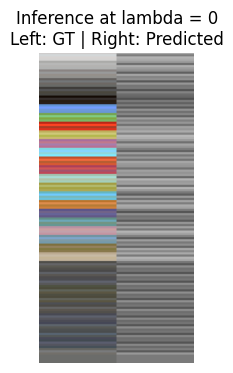

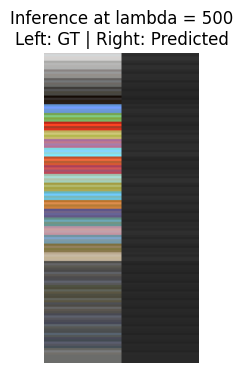

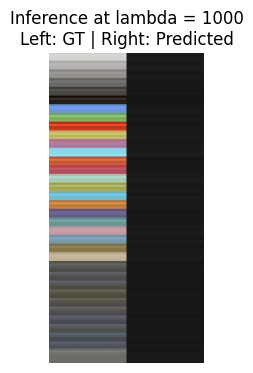

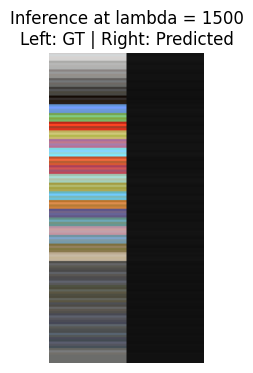

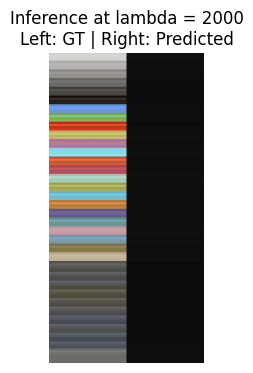

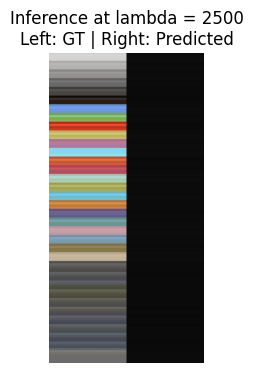

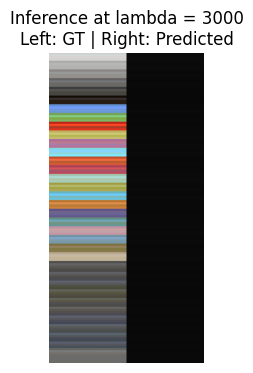

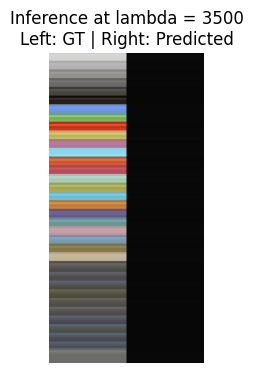

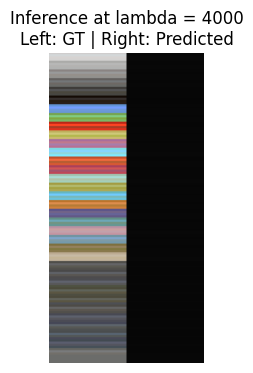

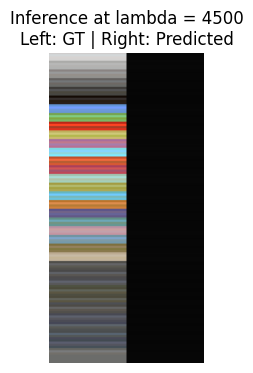

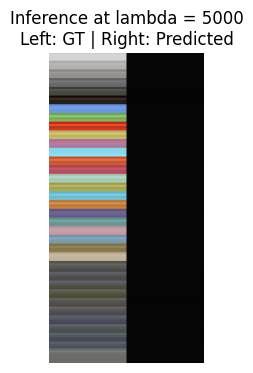

In [58]:

for i in range(0, wRRArray1.shape[0],500):
    wRRvals1 = wRRArray1[i]
    wRRvals2 = wRRArray2[i]
    wRRvals3 = wRRArray3[i]
    y_pred = inference(scan_1_augmented, wRRvals1,wRRvals2,wRRvals3)
    plot_pixel_colors(y,y_pred,"Inference at lambda = %d"%i)


(420,) 0.02754765057117623 0.016894906953391835


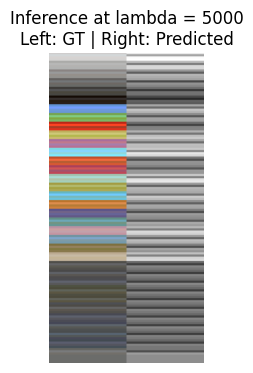

In [59]:

print(y_pred.shape,y_pred.max(),y_pred.min())
    
plot_pixel_colors(y,(y_pred-y_pred.min())/(y_pred.max()-y_pred.min()),"Inference at lambda = %d"%i)